### We will try 3 different models : KNN, Random Forests and SVMs

In [1]:
# import relevant libraries
import warnings
warnings.filterwarnings("ignore")

import pandas
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import SVC                         # SVM
from sklearn.ensemble import RandomForestClassifier # Random forests
from sklearn.neighbors import KNeighborsClassifier  # KNN

from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix


In [2]:
# Read the training data
train_df = pandas.read_csv('./creditdefault_train.csv')
# Display first 5 rows
train_df.head()


,Y,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23
0,1,20000,2,2,1,24,2,2,-1,-1,...,689,0,0,0,0,689,0,0,0,0
1,0,50000,2,2,1,37,0,0,0,0,...,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000
2,0,50000,1,2,1,57,-1,0,-1,0,...,35835,20940,19146,19131,2000,36681,10000,9000,689,679
3,0,50000,1,1,2,37,0,0,0,0,...,57608,19394,19619,20024,2500,1815,657,1000,1000,800
4,0,500000,1,1,2,29,0,0,0,0,...,445007,542653,483003,473944,55000,40000,38000,20239,13750,13770


In [3]:
# Let's look if there are any missing values! 
train_df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 24 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Y       15000 non-null  int64
 1   X1      15000 non-null  int64
 2   X2      15000 non-null  int64
 3   X3      15000 non-null  int64
 4   X4      15000 non-null  int64
 5   X5      15000 non-null  int64
 6   X6      15000 non-null  int64
 7   X7      15000 non-null  int64
 8   X8      15000 non-null  int64
 9   X9      15000 non-null  int64
 10  X10     15000 non-null  int64
 11  X11     15000 non-null  int64
 12  X12     15000 non-null  int64
 13  X13     15000 non-null  int64
 14  X14     15000 non-null  int64
 15  X15     15000 non-null  int64
 16  X16     15000 non-null  int64
 17  X17     15000 non-null  int64
 18  X18     15000 non-null  int64
 19  X19     15000 non-null  int64
 20  X20     15000 non-null  int64
 21  X21     15000 non-null  int64
 22  X22     15000 non-null  int64
 23  X23     150

#### We see that no entries are null, so no data imputation is required

In [4]:
# Value distribution for test data
train_df["Y"].value_counts()



0    11682
1     3318
Name: Y, dtype: int64

#### Note that the data is skewed, we have many more data rows for customers that do not default i.e. Y= 0
#### We will use F1 score to evaluate our model given this skewness

In [5]:
# Let's read the test data now
test_df = pandas.read_csv('./creditdefault_test.csv')



#### Separate out the input features and the target value we want to predict

In [6]:
# target that we want to classify things into
targets = ['Y']

# Separate out the features and target data in both train and test
y_train = train_df[targets]
x_train = train_df.drop(columns = targets) 

# Now do it for test data
y_test = test_df[targets]
x_test = test_df.drop(columns = targets) 



# 1. SVM

In [7]:
# variables to maintain best scores, parameters and model
max_score = 0
max_gamma = None
best_model = None

# Try different gammas
all_gammas = [0.1, 0.05, 0.01, 0.005, 0.001, 0.0005]
all_mean_score = []

for gamma in all_gammas:    
    # initialize the model
    model = SVC(gamma=gamma)
    # cross validation for beter evaluation
    scores = cross_val_score(model, x_train, y_train, cv=5, scoring='f1_macro')
    # calculate mean score
    mean_scores = scores.mean()
    all_mean_score.append(mean_scores)
    # if this score is better, we store the model
    if mean_scores > max_score:
        max_score = mean_scores
        max_gamma = gamma
        best_model = model
        

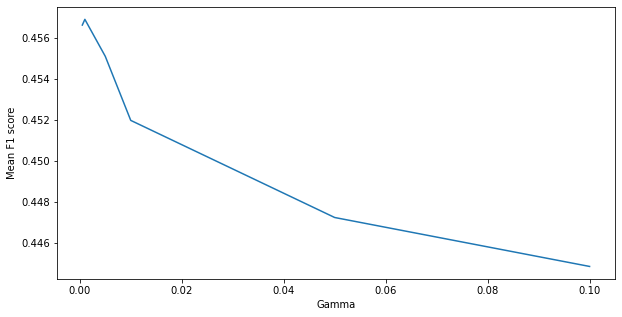

In [8]:
# plot how hyperparameter tuning changes our model scores
plt.figure(figsize=(10,5))
plt.plot( all_gammas, all_mean_score)
plt.xlabel('Gamma')
plt.ylabel('Mean F1 score')
plt.show()


Maximum average F1 score :  0.45690981006375175
              precision    recall  f1-score   support

           0       1.00      0.78      0.88     14908
           1       0.02      0.63      0.03        92

    accuracy                           0.78     15000
   macro avg       0.51      0.71      0.46     15000
weighted avg       0.99      0.78      0.87     15000



<AxesSubplot:>

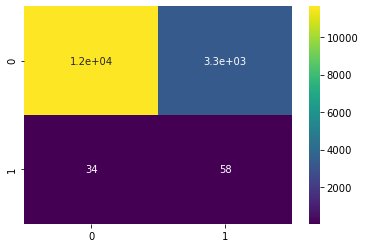

In [9]:
# Now predict on test data, using model with best hyperparameter
print('Maximum average F1 score : ', max_score)
# Fit the model
best_model.fit(x_train, y_train)
# Predict for test data
preds = best_model.predict(x_test)
# Show classification report
print(classification_report(preds , y_test))
# Show heatmap of confusion matrix, to report the required metrics
sns.heatmap(pandas.DataFrame(confusion_matrix(preds , y_test)) , cmap="viridis" , annot = True)


### We observe that best accuracy achieved from SVM on unseen test data is 0.78!

# Random forest classifier

In [10]:
# variables to maintain best scores, parameters and model
max_score = 0
max_param = None
best_model = None

# Try different n_estimator trees in random forest
n_estimators = [1, 10, 20, 50, 100, 200, 250, 500, 750, 1000]
all_mean_score = []

for n_estimator in n_estimators:   
    # initialize the model
    model = RandomForestClassifier(n_estimators=n_estimator)
    # cross validation for beter evaluation
    scores = cross_val_score(model, x_train, y_train, cv=5, scoring='f1_macro')
    # calculate mean score
    mean_scores = scores.mean()
    # if this score is better, we store the model
    all_mean_score.append(mean_scores)
    if mean_scores > max_score:
        # if score is better, update the state
        max_score = mean_scores
        max_param = n_estimator
        best_model = model
        

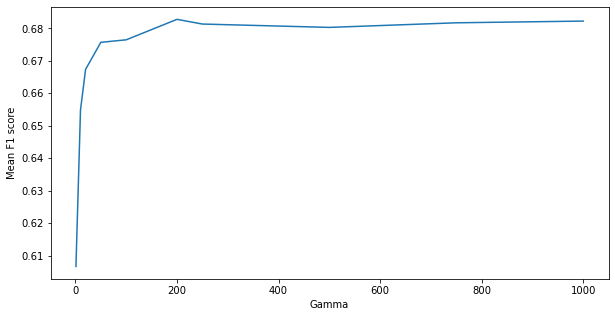

In [11]:
# plot how hyperparameter tuning changes our model scores
plt.figure(figsize=(10,5))
plt.plot( n_estimators, all_mean_score)
plt.xlabel('Gamma')
plt.ylabel('Mean F1 score')
plt.show()


Maximum average F1 score :  0.6827675783868186
              precision    recall  f1-score   support

           0       0.94      0.84      0.89     13106
           1       0.37      0.64      0.47      1894

    accuracy                           0.82     15000
   macro avg       0.66      0.74      0.68     15000
weighted avg       0.87      0.82      0.84     15000



<AxesSubplot:>

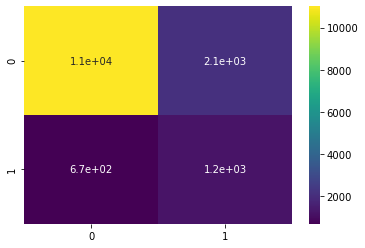

In [12]:
# Now predict on test data, for best hyperparameter
print('Maximum average F1 score : ', max_score)
# Fit the model
best_model.fit(x_train, y_train)
# Predict for test data
preds = best_model.predict(x_test)
# Show classification report
print(classification_report(preds , y_test))
# Show heatmap of confusion matrix, to report the required metrics
sns.heatmap(pandas.DataFrame(confusion_matrix(preds , y_test)) , cmap="viridis" , annot = True)


### We observe that best accuracy achieved from random forest classifier on unseen test data is 0.82!


# K nearest Neighbors

In [13]:
# variables to maintain best scores, parameters and model
max_score = 0
max_param = None
best_model = None

# Try different n_neighbors values for KNN
n_neighbors = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
all_mean_score = []

# try for each hyperparameter value
for n_neighbor in n_neighbors:    
    # initialize the model
    model = KNeighborsClassifier(n_neighbors=n_neighbor)
    # cross validation for beter evaluation
    scores = cross_val_score(model, x_train, y_train, cv=5, scoring='f1_macro')
    # calculate mean score
    mean_scores = scores.mean()
    # if this score is better, we store the model
    all_mean_score.append(mean_scores)
    if mean_scores > max_score:
        # if better score, update the state
        max_score = mean_scores
        max_param = n_neighbor
        best_model = model
        
    

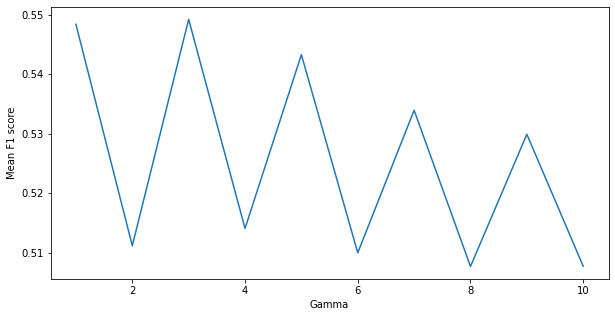

In [14]:
# plot how hyperparameter tuning changes our model scores
plt.figure(figsize=(10,5))
plt.plot( n_neighbors, all_mean_score)
plt.xlabel('Gamma')
plt.ylabel('Mean F1 score')
plt.show()


Maximum average F1 score :  0.5491964390183046
              precision    recall  f1-score   support

           0       0.88      0.80      0.84     12805
           1       0.23      0.35      0.28      2195

    accuracy                           0.73     15000
   macro avg       0.55      0.57      0.56     15000
weighted avg       0.78      0.73      0.76     15000



<AxesSubplot:>

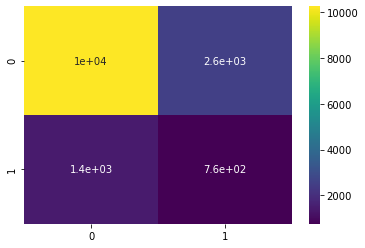

In [15]:
# Now predict on test data, for best hyperparameter
print('Maximum average F1 score : ', max_score)
# Fit the model
best_model.fit(x_train, y_train)
# Predict for test data
preds = best_model.predict(x_test)
# Show classification report
print(classification_report(preds , y_test))
# Show heatmap of confusion matrix, to report the required metrics
sns.heatmap(pandas.DataFrame(confusion_matrix(preds , y_test)) , cmap="viridis" , annot = True)


### We observe that best accuracy achieved from K-nearest neighbors on unseen test data is 0.73!

### We have two measures of better model - F1 score and accuracy. 
#### For both of these measures, we see that random forest classifier performs better than all other models, so we choose that as our best model
#### We already performed the accuracy calculations on unseen test data for all these models, and we see that for random forest classifier, the best accuracy is 82%!!

